# [DEMI](https://arxiv.org/pdf/2010.01766.pdf) for estimating mutual information (20-d Gaussian)

We demo [DEMI](https://arxiv.org/pdf/2010.01766.pdf) for estimating mutual information between two 20-d Gaussian variables $x$ and $y$.

In our development, we will find it convenient to define a Bernoulli random variable  $z\in\{0,1\}$ and to "lift" the distribution $p(x,y)$ to the product space $\mathcal{X}\times\mathcal{Y}\times\{0,1\}$. We thus define a family of distributions parametrized by $\alpha\in(0,1)$ as follows:
\begin{align}
p_*(x,y|z=1;\alpha) &= p(x,y), \\
p_*(x,y|z=0;\alpha) &= p(x)p(y),\\
p_*(z=1;\alpha) &= 1-p_*(z=0;\alpha)=\alpha.
\end{align}

It implies the mutual information between $x$ and $y$ can be expressed as:
\begin{align}
    \hat{I}_{p}(x,y)
    &=
    \frac{1}{n} \sum_{i=1}^n \log 
    \frac{p_*(z_i = 1 | x_i , y_i )}{p_*(z_i = 0 | x_i , y_i )} 
    - \log \frac{\alpha}{1-\alpha} \\
    &=\frac{1}{n} \sum_{i=1}^n \text{logit}\left[p_*(z_i = 1 | x_i , y_i )\right] 
    -\text{logit}[\alpha],
\end{align}

where $\text{logit}[u]\stackrel{\Delta}{=}\log\,\frac{u}{1-u}$ is the log-odds function.

Our key idea is to approximate the latent posterior distribution $p_*(z=1|x,y)$ by a classifier that is trained to distinguish between the joint distribution $p(x,y)$ and the product distribution $p(x)p(y)$.

## Define hyper-parameters and training device

We demo DEMI on 4 pairs of 20-d Gaussian variables, 
whose mutual information values are 0.1, 15, 25, 40, respectively.

We generate 160K samples from each Gaussian variable as the training set for DEMI, and 10K samples as the test set for DEMI to estimate mutual information.


In [1]:
gaussian_length = 20
n_train = 300000
n_test = 10000

In [2]:
import torch

assert torch.cuda.is_available(), "No GPU/CUDA is detected!"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generate Gaussian samples

In [3]:
import os
import numpy as np

from gaussian_sampler import generate_gaussian_samples, mi_to_rho

n=1
data_dir = os.path.join('./data', 'gaussian_samples_'+str(n))
while os.path.isdir(data_dir):
    n+=1
    data_dir = os.path.join('./data', 'gaussian_samples_'+str(n))
os.makedirs(data_dir)
sample_set = 'gaussian_samples_'+str(n)

data_x_train = {}
data_y_train = {}

data_x_test = {}
data_y_test = {}

for mi in [0.1, 5., 10., 15., 20., 25.]:
    rho = mi_to_rho(gaussian_length, mi)

    _, _, samples_joint_xy, _ = generate_gaussian_samples(gaussian_length, rho, n_train)
    samples_x = samples_joint_xy[:, :gaussian_length]
    samples_y = samples_joint_xy[:, gaussian_length:]
    data_x_train[str(mi)] = samples_x
    data_y_train[str(mi)] = samples_y
    np.save(os.path.join(data_dir, 'samples_x_mi{:.1f}_train'.format(mi)), samples_x)
    np.save(os.path.join(data_dir, 'samples_y_mi{:.1f}_train'.format(mi)), samples_y)

    _, _, samples_joint_xy, _ = generate_gaussian_samples(gaussian_length, rho, n_test)
    samples_x = samples_joint_xy[:, :gaussian_length]
    samples_y = samples_joint_xy[:, gaussian_length:]
    data_x_test[str(mi)] = samples_x
    data_y_test[str(mi)] = samples_y
    np.save(os.path.join(data_dir, 'samples_x_mi{:.1f}_test'.format(mi)), samples_x)
    np.save(os.path.join(data_dir, 'samples_y_mi{:.1f}_test'.format(mi)), samples_y)

## Visualize the training sets

We visualize the 4 sets of Gaussian sample pairs that are drawn from 4 pairs of 20-d Gaussian variables respectively.

In [4]:
import os
import numpy as np

# samples_x = np.load(os.path.join(data_dir, 'samples_x_mi0.1_train.npy'))
# samples_y = np.load(os.path.join(data_dir, 'samples_y_mi0.1_train.npy'))

samples_x = data_x_train['0.1']
samples_y = data_y_train['0.1']

num_train_samples = samples_x.shape[0]
dim_x = samples_x.shape[1]
dim_y = samples_y.shape[1]

print('Number of training samples: {}'.format(num_train_samples))
print('Dimension of the Gaussian variable x: {}'.format(dim_x))
print('Dimension of the Gaussian variable y: {}'.format(dim_y))

Number of training samples: 300000
Dimension of the Gaussian variable x: 20
Dimension of the Gaussian variable y: 20


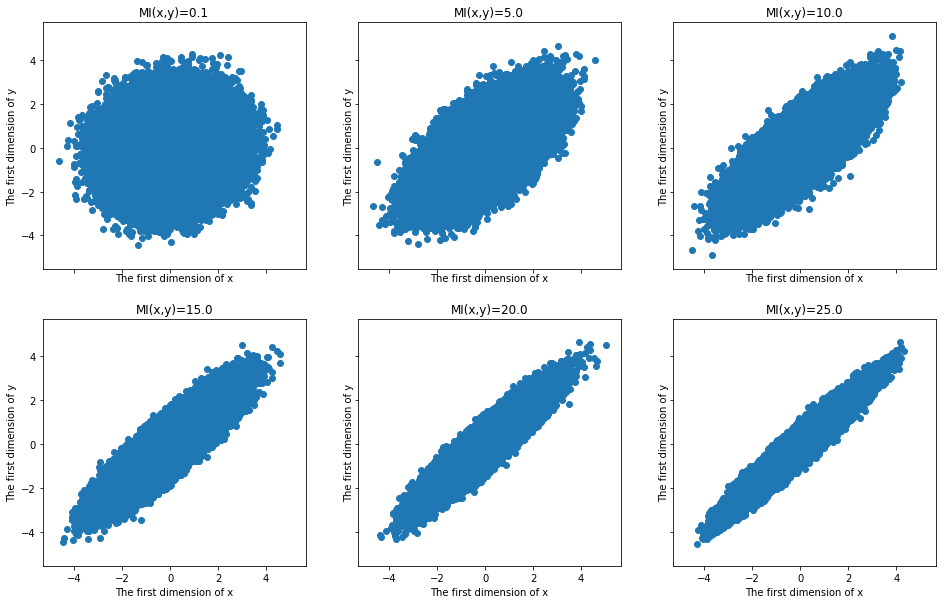

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(16,10), sharex=True, sharey=True)

j=0
for mi in [0.1, 5., 10., 15., 20., 25.]:
#     samples_x = np.load(os.path.join(data_dir, 'samples_x_mi{:.1f}_train.npy'.format(mi)))
#     samples_y = np.load(os.path.join(data_dir, 'samples_y_mi{:.1f}_train.npy'.format(mi)))
   
    samples_x = data_x_train[str(mi)]
    samples_y = data_y_train[str(mi)]

    samples_d1_x = samples_x[:,0]
    samples_d1_y = samples_y[:,0]

    axes[int((j-j%3)/2),int(j%3)].scatter(samples_d1_x, samples_d1_y)
    axes[int((j-j%3)/2),int(j%3)].set_xlabel('The first dimension of x')
    axes[int((j-j%3)/2),int(j%3)].set_ylabel('The first dimension of y')
    axes[int((j-j%3)/2),int(j%3)].set_title('MI(x,y)={:.1f}'.format(mi))
    
    j+=1

plt.show()

## Train the DEMI classifier

To approximate the latent posterior distribution $p_*(z=1|x,y)$, we train a classifier $q(z=1|x,y;\theta,\mathcal{T})$ parameterized by $\theta$ and derived from the training set $\mathcal{T}$. 

If $q(z=1|x,y;\theta,\mathcal{T})$ accurately approximates the posterior distribution $p_*(z=1|x,y;\alpha)$, then we can use this classifier~$q$ instead of $p_*(z=1|x,y;\alpha)$ to estimate MI.

We follow the widely used maximum likelihood approach to estimating the classifier's parameters $\theta$ and form the cross-entropy loss function 

\begin{align}
\ell(\theta;\mathcal{T}) 
&= - \frac{1}{m} \sum_{j=1}^{m} \log q(z^j|x^j,y^j;\theta,\mathcal{T}) \\
&= - \frac{1}{m} \sum_{j=1}^{m} z^j \log q(z^j=1|x^j,y^j;\theta,\mathcal{T})+(1-z^j) \log (1-q(z^j=1|x^j,y^j;\theta,\mathcal{T})  )
\end{align}

to be minimized to determine the optimal value of parameters $\hat{\theta}$.

In [6]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam, lr_scheduler

from utils import permute_samples, cat_samples

def train(demi_discriminator, train_dataloader, num_train_epochs, learning_rate, output_dir):
    param_optimizer = list(demi_discriminator.named_parameters())
    optimizer_parameters = demi_discriminator.parameters()
    optimizer = Adam(optimizer_parameters, lr=learning_rate)
    
    scheduler = lr_scheduler.MultiStepLR(optimizer, 
                                         milestones=[int(num_train_epochs/3),int(num_train_epochs*2/3)],
                                         gamma=0.5)

    BCE_loss_criterion = BCEWithLogitsLoss()

    demi_discriminator.train()
    for epoch in range(num_train_epochs):
        tr_epoch_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            optimizer.zero_grad()

            batch = tuple(t.to(device=device, non_blocking=True) for t in batch)
            x_samples, y_samples = batch

            permuted_x_samples, permuted_y_samples = permute_samples(x_samples, y_samples)
            new_x_samples, new_y_samples, batch_labels = cat_samples(x_samples, y_samples,
                                                                     permuted_x_samples, permuted_y_samples)

            discriminator_input = torch.cat((new_x_samples, new_y_samples), 1)

            discriminator_logits = demi_discriminator(discriminator_input)
            loss = BCE_loss_criterion(discriminator_logits, batch_labels)
            loss.backward()
            optimizer.step()

            tr_epoch_loss += loss.item()
        scheduler.step()

    checkpoint_dir = os.path.join(output_dir, 'checkpoint-{}'.format(epoch+1))
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    demi_discriminator.save_pretrained(checkpoint_dir)
    
    return checkpoint_dir, tr_epoch_loss

In [7]:
from torch.utils.data import DataLoader

from discriminator import Discriminator
from utils import load_and_cache_examples, GaussianSampleDataset

mlp_hidden_dims = [256,256]
learning_rate = 2e-3
num_train_epochs=20

for mi in [0.1, 5., 10., 15., 20., 25.]:
#     x_samples_path = os.path.join(data_dir, 'samples_x_mi{:.1f}_train.npy'.format(mi))
#     y_samples_path = os.path.join(data_dir, 'samples_y_mi{:.1f}_train.npy'.format(mi))

#     train_dataset = load_and_cache_examples(x_samples_path, y_samples_path)
    
    print('**Starting DEMI classifier training**')
    
    samples_x = data_x_train[str(mi)]
    samples_y = data_y_train[str(mi)]
    train_dataset = GaussianSampleDataset(samples_x,
                                          samples_y)
    train_dataloader = DataLoader(train_dataset, shuffle=True,
                                  batch_size=64, num_workers=8,
                                  pin_memory=True)

    output_dir = './output/'+sample_set+'/{:d}d_{:.1f}/'.format(gaussian_length, mi)
    directories = [output_dir]
    for directory in directories:
        if not(os.path.exists(directory)):
            os.makedirs(directory)

    demi_discriminator = Discriminator(sample_length=gaussian_length,
                                       hidden_dims=mlp_hidden_dims)
    demi_discriminator.to(device)

    checkpoint_dir, tr_loss = train(demi_discriminator, train_dataloader, 
                                    num_train_epochs, learning_rate, output_dir)
    print('**Finished DEMI classifier training**')
    print('Final epoch training loss: {}'.format(tr_loss))
    print('Final checkpoint path: {}'.format(checkpoint_dir))

**Starting DEMI classifier training**
**Finished DEMI classifier training**
Final epoch training loss: 3113.077821314335
Final checkpoint path: ./output/gaussian_samples_14/20d_0.1/checkpoint-20
**Starting DEMI classifier training**
**Finished DEMI classifier training**
Final epoch training loss: 486.2001621630043
Final checkpoint path: ./output/gaussian_samples_14/20d_5.0/checkpoint-20
**Starting DEMI classifier training**
**Finished DEMI classifier training**
Final epoch training loss: 52.21059569859062
Final checkpoint path: ./output/gaussian_samples_14/20d_10.0/checkpoint-20
**Starting DEMI classifier training**
**Finished DEMI classifier training**
Final epoch training loss: 5.422713233596966
Final checkpoint path: ./output/gaussian_samples_14/20d_15.0/checkpoint-20
**Starting DEMI classifier training**
**Finished DEMI classifier training**
Final epoch training loss: 1.3664544281711357
Final checkpoint path: ./output/gaussian_samples_14/20d_20.0/checkpoint-20
**Starting DEMI class

# Test DEMI on mutual information estimation (20-d Gaussian) 

In [8]:
from utils import reshape_samples

def demi_estimator(demi_discriminator, test_dataloader):
    mi_ratios = []
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device=device, non_blocking=True) for t in batch)
        x_samples, y_samples = batch
        x_samples, y_samples = reshape_samples(x_samples, y_samples)
        discriminator_input = torch.cat((x_samples, y_samples), 1)

        output = demi_discriminator(discriminator_input)
        output_logits = output.detach().cpu().numpy()

        for i in output_logits.flatten():
            mi_ratios.append(float(i))

    mi_estimate = np.mean(mi_ratios)

    return mi_estimate

In [9]:
mi_true = []
mi_estimates = []
for mi in [0.1, 5., 10., 15., 20., 25.]:
#     x_samples_path = os.path.join(data_dir, 'samples_x_mi{:.1f}_test.npy'.format(mi))
#     y_samples_path = os.path.join(data_dir, 'samples_y_mi{:.1f}_test.npy'.format(mi))

#     test_dataset = load_and_cache_examples(x_samples_path, y_samples_path)
   
    samples_x = data_x_test[str(mi)]
    samples_y = data_y_test[str(mi)]
    test_dataset = GaussianSampleDataset(samples_x,
                                          samples_y)
    test_dataloader = DataLoader(test_dataset, shuffle=True,
                                 batch_size=64, num_workers=8,
                                 pin_memory=True)

    output_dir = './output/'+sample_set+'/{:d}d_{:.1f}/'.format(gaussian_length, mi)
    checkpoint_dir = os.path.join(output_dir, 'checkpoint-{}'.format(num_train_epochs))

    demi_discriminator = Discriminator.from_pretrained(checkpoint_dir,
                                                       sample_length=gaussian_length,
                                                       hidden_dims=mlp_hidden_dims)
    demi_discriminator.to(device)
    
    mi_estimates.append(demi_estimator(demi_discriminator, test_dataloader))
    mi_true.append(mi)

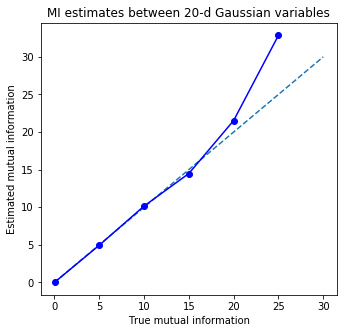

In [10]:
plt.figure(figsize=(5.3,5))
diagnoal1 = [0, 30]
diagnoal2 = [0, 30]
plt.plot(diagnoal1, diagnoal2, '--')

plt.errorbar(mi_true, mi_estimates, capsize=3, color='b', marker='o')
plt.title('MI estimates between 20-d Gaussian variables')
plt.xlabel('True mutual information')
plt.ylabel('Estimated mutual information')
plt.show()
